# Creating HAS-model embeddings for entities in a KG
The purpose of these will be for assessing entities' similarities to one another. This measure of similarity between entities will in turn be used to assess the distinctiveness of labels that have previously been created and filtered for this KG.

## Pre-requisite steps to run this notebook
1. You have already created a type_mapping.tsv file (this is done in the candidate label creation notebook
2. gensim is a dependency. You can install it with `pip install --upgrade gensim`, or if you want to use Anaconda, `conda install -c conda-forge gensim`

In [232]:
import os
import random
import numpy as np
from gensim.models import Word2Vec
import graph_tool.all as gt
from kgtk.gt.gt_load import load_graph_from_kgtk
from kgtk.io.kgtkreader import KgtkReader
import pathlib
import matplotlib.pyplot as plt
from collections import Counter
from h_path_walks import build_corpus

## parameters

**Embedding model parameters**  
*undirected*: Treat graph as undirected *(In-progress, this param is currently not used)*  
*num_walks*: Number of random walks to start at each node  
*walk_length*: Length of random walk started at each node  
*representation_size*: Number of latent dimensions to learn from each node  
*window_size*: Window size of skipgram model  
*workers*: Number of parallel processes  

**File/Directory parameters**  
*output_filename*: Name for output representation file.  
*item_file*: File path for the file that contains entity to entity relationships (e.g. wikibase-item).  
*label_file*: File path for the file that contains wikidata labels.  
*work_dir*: Folder where files created by this notebook should be saved.  
*store_dir*: Path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [272]:
# Embedding model params
#undirected = True TODO - choose either directed or undirected and delete this param, or make this a param that we pay attention to in later code.
num_walks = 10
walk_length = 10
representation_size = 64
window_size = 5
workers = 32

# File/Directory params
output_filename = "HAS_model"
item_file = "../../Q44/data/Q44.part.wikibase-item.tsv"
label_file = "../../Q44/data/Q44.label.en.tsv"
work_dir = "../../Q44/profiler_work_string_and_untrimmed_quantity"
store_dir = "../../Q44"

# output_filename = "HAS_model"
# item_file = "../../Q154/data/parts/claims.wikibase-item.tsv.gz"
# label_file = "../../Q154/data/parts/labels.en.tsv.gz"
# work_dir = "../../Q154/profiler_work"
# store_dir = "../../Q154"

### Process parameters and set up variables / file names

In [273]:
# Ensure paths are absolute
item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
    
# Create directories
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
output_dir = "{}/HAS_embeddings".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
output_file = "{}/{}".format(output_dir, output_filename)

# Setting up environment variables 
os.environ['ITEM_FILE'] = item_file
os.environ['LABEL_FILE'] = label_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['OUT'] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

### Helpers

In [274]:
def plot_walk_length_dist(walks):
    print("Number of walks: {}".format(len(walks)))
    walk_lengths = [len(arr) for arr in walks]
    print("Number of walks of each length:")
    counts_str = ", ".join(["{} : {}".format(key,value) for key,value in sorted(Counter(walk_lengths).items())])
    print(counts_str)
    fig, ax = plt.subplots()
    ax.hist(walk_lengths,bins=np.arange(12)-.5)
    ax.set_ylabel('Number of walks')
    ax.set_xlabel('Walk length')
    plt.show()
    
def plot_distinct_nodes_in_walks(walks):
    print("Number of walks: {}".format(len(walks)))
    count_distinct_nodes = [len(set(arr)) for arr in walks]
    print("Number of walks by number of unique nodes visited:")
    counts_str = ", ".join(["{} : {}".format(key,value) for key,value in sorted(Counter(count_distinct_nodes).items())])
    print(counts_str)
    fig, ax = plt.subplots()
    ax.hist(count_distinct_nodes,bins=np.arange(12)-.5)
    ax.set_ylabel('Number of walks')
    ax.set_xlabel('Number of unique nodes visited')
    plt.show()

Start with empty corpus of walks. We'll add to this in the following steps.

In [300]:
walks = []

### 1. H-Paths
These random walks are intended to detect similarity due to homophily. Random walks are performed in a DFS manner

#### 1.1 H-Paths - loading entity to entity edges into a Graph-Tool graph
loading two versions to look at - one with directed edges and one with undirected edges. The default in the authors' code is undirected, though they do not mention if this is what they used for the results that they presented in the paper.

In [276]:
kr = KgtkReader.open(pathlib.Path(item_file))
g_directed = load_graph_from_kgtk(kr, directed=True, hashed=True)
kr = KgtkReader.open(pathlib.Path(item_file))
g_undirected = load_graph_from_kgtk(kr, directed=False, hashed=True)

In [277]:
print("This graph has {} vertices and {} edges".format(len(g_directed.get_vertices()), len(g_directed.get_edges())))

This graph has 11294 vertices and 20516 edges


#### 1.2 H-Paths - Build corpus of random walks

**First for directed representation**

In [278]:
%%time
h_walks_directed = build_corpus(g_directed, walk_length, num_walks)

CPU times: user 5.97 s, sys: 206 ms, total: 6.18 s
Wall time: 6.27 s


Let's look at how many walks we have and how long they are (max walk length is 10).

Number of walks: 112940
Number of walks of each length:
1 : 109640, 2 : 2031, 3 : 985, 4 : 206, 5 : 62, 6 : 13, 7 : 2, 8 : 1


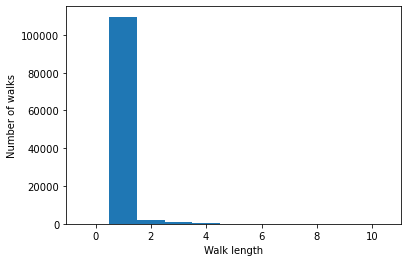

In [279]:
plot_walk_length_dist(h_walks_directed)

Checking that this makes sense...  
Let's look at an example of a walk of length 1 and verify that it has no outbound edges in the graph.

In [280]:
index = walk_lengths.index(1)
print("{} has a walk length of {}".format(h_walks[index][0], walk_lengths[index]))

Q1278032 has a walk length of 1


In [281]:
!kgtk query -i $ITEM_FILE --graph-cache $STORE \
--match '`'"$ITEM_FILE"'`: (n1)-[l {label:p}]->(n2)' \
--return 'n1 as n1, p as prop, n2 as n2' \
--where 'n1 = "Q1278032"'

n1	prop	n2


And as we can see above, there is no outbound edge from Q1278032 ('East Staffordshire') in the graph

**Now for undirected representation**

In [282]:
%%time
h_walks_undirected = build_corpus(g_undirected, walk_length, num_walks)

CPU times: user 9.6 s, sys: 1.07 s, total: 10.7 s
Wall time: 10.8 s


Number of walks: 112940
Number of walks of each length:
10 : 112940


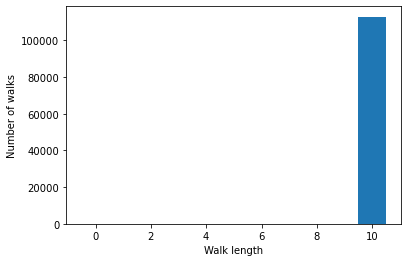

In [283]:
plot_walk_length_dist(h_walks_undirected)

Since these walks are on an undirected graph, it might be informative to look at how many unique vertexes we visit in each walk.

Number of walks: 112940
Number of walks by number of unique nodes visited:
2 : 28, 3 : 150, 4 : 532, 5 : 2382, 6 : 18180, 7 : 29919, 8 : 36810, 9 : 20678, 10 : 4261


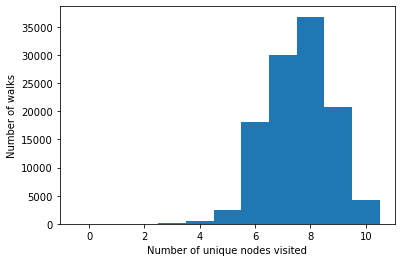

In [284]:
plot_distinct_nodes_in_walks(h_walks_undirected)

We'll use the undirected representation's h-path walks. Adding them to the list of paths that will later be fed to a skip-gram model.

In [301]:
walks.extend(h_walks_undirected)

### 2. A-Paths (TODO)

### 3. S-Paths (TODO)

### 4. Use Skip-Gram model on the combined set of random walks to learn representations for the entities
Code is currently using the walks created by the undirected graph representation

In [302]:
model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, sg=1, hs=1,
                 workers=workers)
model.wv.save_word2vec_format(output_file)

Now we have embeddings for the entities. Here is what Beer looks like:

In [304]:
model.wv["Q44"]

array([-0.10504546, -0.5197131 ,  0.63982505,  0.1441161 ,  0.60569906,
       -0.69399446,  0.4205355 , -0.18196362,  0.24686256, -0.8131254 ,
       -0.01032642,  0.5521092 ,  0.289288  ,  0.24916527, -0.01905111,
        0.5654449 , -0.6118205 ,  0.80521184,  0.8276056 ,  0.7351372 ,
        0.87236065,  0.18068133, -0.10869325,  0.8826329 ,  0.16151546,
       -0.39793345, -0.00493379, -0.30667162, -0.2636516 , -0.5383527 ,
        0.6018666 , -0.01954279, -1.0817765 , -0.01720298,  0.8762579 ,
        0.65152025, -0.31066707, -0.56997454, -0.51779675, -0.12303738,
       -0.5793813 ,  0.55956376, -0.39791596, -0.77485216,  0.03920611,
       -0.27818367, -0.02001944, -0.5404001 ,  0.07983732, -0.0445268 ,
        0.13702728,  0.19984083,  0.87586343, -0.00944167,  0.08037495,
        0.48493955, -0.6510796 ,  0.22250324,  0.33588412, -0.16469076,
        0.07030386,  0.5429082 ,  0.35188052, -0.7162532 ], dtype=float32)